In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 使用 GPU 0，

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
#clear_output(wait=True)
import math
from tensorflow.contrib import rnn
# Hyper Parameters

timestep_size =2
LR_G = 0.0001          # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
HIDDEN_SIZE = 10        # think of this as number of ideas for generating an art work (Generator)


BATCH_SIZE = 100#一個月 4 * 5
                #半年 6 * 4 * 5 = 120
OUTPUT_SIZE = 30

INPUT_SIZE = OUTPUT_SIZE
t = 5
label_num = 1
adjust_price_quantity=0.5
adjust_price = 0#給予正負號

lstm = True
#_LST = not lstm
F_resnet_layers_num = OUTPUT_SIZE
a_Normalization = True
load = False

system_dynamic = False

C:\Users\yu19\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#上漲,下跌%數
def Normarlization(data):
    data2 = []
    for i in range(0,len(data)-1):
        today = data[i]
        tomorrow = data[i+1]
        
        val =np.log(tomorrow) - np.log(today)
        #val = tomorrow / today
        data2.append(val)
       
    return data2

def Shuffle(data):
    np.random.shuffle(data)
    return data
def MinMaxNormalization(data):
    assert np.array(data).ndim == 1 
    
    data = [ (float(f)-np.min(data) )/ (np.max(data)-np.min(data) ) for f in data]
    
    return data
def MeanStdNormalization(data):
    assert np.array(data).ndim == 1
    data = [float(f)-np.mean(data) /np.std(data) for f in data]
    return data

def SlidingWindow(array,size):
    iArr = []
    for i in range(0,len(array)-size):
        jArr = []
        for j in range(i,i+size):
            jArr.append(array[j])
        iArr.append(jArr)
    return iArr


In [4]:
from os import listdir
from os.path import isfile, join

import xlrd
disk = './'

mypath = disk+'quantity'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]



def readFromFiles(files):
    data = []
    mypath = disk+'quantity'
    for i in range(0,len(files)):
        path = mypath+'/'+files[i]
        date = files[i][2:len(files[i])-4]
        #print(date)
        wb = xlrd.open_workbook(path)
        ws = wb.sheets()[0]

          
        for j in range(0,ws.nrows):
            code = ws.cell(j,1).value
            #print(code)
            if str(code)[0:4] == str(2330):
                quantity = ws.cell(j,3).value
                data.append([date,quantity])
                #print(quantity)
                break
        
    return data

   
issued_shares = readFromFiles(onlyfiles)




In [5]:
def SpecialSplit(line):
    cannotSplit = False
    splitIndexs = []
    #print(line)
    for index in range(0,len(line)):
        
        c = line[index]
        #print(c)
        if c == '"':
            cannotSplit = not cannotSplit
            continue
        if c ==',' and cannotSplit == False:
            splitIndexs.append(index)
            #print('i catch ,')
    #print(splitIndexs)
    startIndex = 0
    splitLine = []
    for index in splitIndexs:
        splitLine.append(line[startIndex:index])
        #print('???')
        startIndex=index+1
    splitLine.append(line[startIndex:len(line)-1])
    splitLine2 = []
    for l in splitLine:
        s = ''
        for c in l:
            if c !='"':
                s += c
        splitLine2.append(s)
    return splitLine2

In [6]:


#股票資料2007-2018            
#reader =  open(disk+'半導體股票資料.csv','r',encoding='BIG5')
reader =  open(disk+'股票資料2007-2018.csv','r',encoding='BIG5')
colName = reader.readline()
dates= []
rows = []
def fitNumber(s):
    for c in s:
        if c not in [str(f) for f in range(0,10)]:
            return False
    return True
check = False
for line in reader.readlines():
    lines = SpecialSplit (line)
    #print(line)
    #print(lines)
    if len(lines[0])==4 and len(lines[1])<=2 and len(lines[2])<=2 and fitNumber(lines[0]) and fitNumber(lines[1]) and fitNumber(lines[2]):
        if len(lines[1])==1 :
            lines[1] = '0'+lines[1]
            
            
            
        if len(lines[2]) == 1:
            lines[2] = '0'+lines[2]
            
        
        
        check = True    
        date = (lines[0]+lines[1]+lines[2])
        #print(date)
    if lines[0] == '2330':
        if check:
            #print(date)
            check = False
            dates.append(date)
            rows.append(lines)
    
# print(rows)
# ##3 筆數
# ##8 收盤價
# ##5開盤價
Quantity = [ line[3]for line in rows]
Price = [line[5] for line in rows]
Quantity= [ float((f.replace('"','')).replace(',','')) for f in Quantity]


Price = [ float(f) for f in Price]



In [7]:

def RestorePrice(Price,dates,date,interestRate,NumOfShare):
    startIndex = -1
    for i in range(0,len(dates)):
        if date == dates[i]:
            startIndex = i
    Price = Price[0:startIndex] + [(f*(1+NumOfShare/10)+ interestRate) for index,f in enumerate(Price) if index >=startIndex]
   
    return Price



In [8]:
#issued_shares

In [9]:
#kill not in issued_shares
select_index = []
for index in  range(0,len(dates)):
    check = False
    for [date,j] in issued_shares:
        #print(dates[index][0:6])
        if dates[index][0:6] == date:
            #print(dates[index][0:6],date)
            check=True
            break
    if check:
        select_index.append(index)
print(len(select_index))

dates = [f for index,f in enumerate(dates) if index in select_index]

Price = [f for index,f in enumerate(Price) if index in select_index]
Quantity = [f for index,f in enumerate(Quantity) if index in select_index]

mean_Price = np.mean(Price)

2832


In [10]:
def GenerateQuantity(dates,issued_shares):
    data = []
    for date in dates:
        i = date[0:6]
        check = False
        #print(i)
        for [d,q] in issued_shares:
            #print(d,q)
            
            if d == i:
                data.append(q)
                #print(i,q)
                check = True
        if not check:
            print(i)
                
    return data

print(len(issued_shares) ,len(dates))
#print(issued_shares[0][0])

138 2832


In [11]:
issued_shares = GenerateQuantity(dates,issued_shares=issued_shares)


In [12]:
assert len(issued_shares) == len(dates)


2832 2831 2832


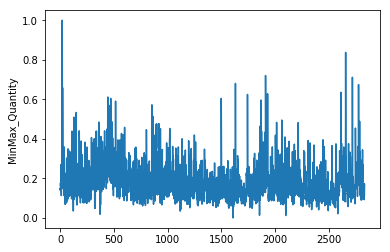

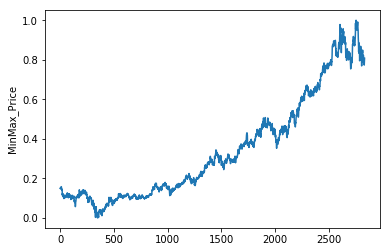

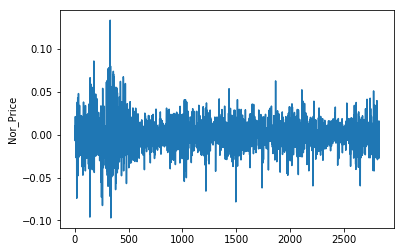

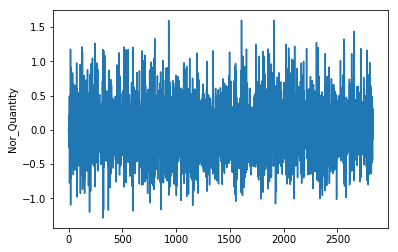

In [13]:
Nor_Quantity = Normarlization(Quantity)
Nor_Price= Normarlization(Price)


print(len(issued_shares),len(Nor_Price),len(Price))





MinMax_Quantity = MinMaxNormalization(Quantity)


MinMax_Price = MinMaxNormalization(Price)

plt.plot(MinMax_Quantity)
plt.ylabel('MinMax_Quantity')
plt.show()
plt.plot(MinMax_Price)
plt.ylabel('MinMax_Price')
plt.show()



plt.plot(Nor_Price)
plt.ylabel('Nor_Price')
plt.show()

plt.plot(Nor_Quantity)
plt.ylabel('Nor_Quantity')
plt.show()


In [14]:

# def Norlabel(data,Quantile,rangeofvalue=2,start_value = -1):
#     """
#     大跌 中蝶 小跌 0 小漲 中漲 大漲
#     """
#     labelN = -1
#     data2 = []
#     Negative_index = [index for index,f in enumerate(data) if f <= Quantile[0]]
#     Postive_index = [index for index,f in enumerate(data) if f >= Quantile[1]]
#     print(len(Negative_index))
#     print(len(Postive_index))
#     print(len(data) - len(Negative_index) - len(Postive_index))
    
#     for i in range(0,len(data)):
#         if i in Negative_index:
#             data2.append([-1])
#         elif i in Postive_index:
#             data2.append([1])
#         else:
#             data2.append([0])
#     return data2

# def Norlabel2(data):
#     """
#     大跌 中蝶 小跌 0 小漲 中漲 大漲
#     """
    
#     data2 = []
#     for i in data:
#         v = 0
#         if i >=1.1:
#             v = 1
#         elif i <= 0.9:
#             v = -1
#         data2.append(v)
#     return data2
        

In [15]:
#Quantile_Price

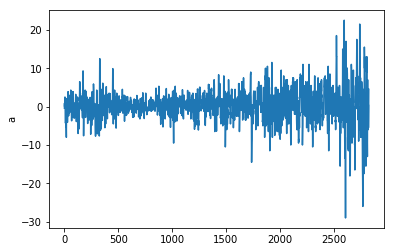

-1.8999999999999986 -1.7000000000000028
5 Price_a len 2827


In [16]:
#a = 2x / t^2
#計算a

def cal_a(data,t):
    arr = []
    for i in range(0,len(data)-t):
        if system_dynamic:
            _a = 2*( np.subtract(data[i+t],(data[i]))  ) / (t**2)
        else:
            _a = ( np.subtract(data[i+t],(data[i]))  ) 
        
        #_a = (2*_a)/ t
        arr.append(_a)
    return arr

def restore_a(y_price,a):
    
    #_a = 2*(data[i] - data[i-1]) / t**2
    #_a * t**2 = 2*(data[i] - data[i-1])
    
    #(_a * t/2) + data[i-1] = data[i]
    
    t_price = (a * (t**2) )/2 + y_price 
    
    return t_price

Price_a = cal_a(Price,t)

plt.plot(Price_a)
plt.ylabel('a')
plt.show()

print(Price_a[37],Price_a[38])
store_price_a = np.array(Price_a)
print(t,'Price_a len',len(Price_a))

In [17]:
#Price_a[38] = 第38天預測43天的資料

Price[43],Price[38]
_a = 2*( np.subtract(Price[42],Price[37])  ) / (t**2)
print(_a,Price[43],Price[38])

-0.15199999999999989 60.8 62.5


'## DeExtremeValue

In [18]:


def DeNormalization_a(a,Price_a_min,Price_a_max):
    a = np.float32(a)
    assert np.ndim(a) == 0
    #a = _a - Price_a_min /(Price_a_max - Price_a_min)
    #_a = (Price_a_max - Price_a_min) * a+ Price_a_min
    _a = np.subtract(Price_a_max,Price_a_min)
    _a = np.multiply(_a,a)
    _a = np.add(_a,Price_a_min)
    
    
    return _a



def DeExtremeValue(data):
    data_mean = np.mean(data)
    data_std = np.std(data)
    data_min = data_mean - 2*data_std
    data_max = data_mean + 2*data_std
    new_arr = []
    for p in data:
        _p = p

        if p> data_max:
            _p = data_max
        elif p< data_min:
            _p = data_min
        new_arr.append(_p)
    return new_arr,data_min,data_max



In [19]:
print(len(Price),len(Price_a),len(Nor_Price),len(Nor_Quantity),len(issued_shares))

2832 2827 2831 2831 2832


## Normalization

In [20]:
asdasd = 0
assert np.ndim(asdasd) == 0

In [21]:
#產生值
if t >1:
    TaxValue =np.multiply(Price[1:-t],Quantity[1:-t])
    TaxValue = TaxValue.tolist()
else:
    TaxValue =np.multiply(Price[1:],Quantity[1:])
    TaxValue = TaxValue.tolist()

#做完正規化後的Price少一天 故此

MarketValue =np.multiply(Price[1:],issued_shares[1:])
MarketValue = MarketValue.tolist()

issued_shares = issued_shares[1:]


Price_a = Price_a[1:]
dates = dates[1:]

In [22]:
"""
正常股票 0 ~ 
正規化   1 ~ 
五天後   6 7 8 .... END


"""

if t >1:
    #少了ˊ幾天可以預測
    Nor_Price = Nor_Price[:(-t)]
    Nor_Quantity = Nor_Quantity[:(-t)]
    issued_shares = issued_shares[:(-t)]
    MarketValue = MarketValue[:(-t)]
    dates = dates[:(-t)]
    
print(len(Price_a) , len(Nor_Price) )

#assert(len(Price_a) == len(Nor_Price))


"""
需要前 N 天的資料才能預測，故刪除不到N天的資料
"""


Predict_n_day = OUTPUT_SIZE

Price_a = Price_a[Predict_n_day:]
#MarketValue 由第二天價格 * 發行數量所得
#需要最後預測的市值

MarketValue = MarketValue[(Predict_n_day-1):-1]
TaxValue = TaxValue[(Predict_n_day-1):-1]
dates = dates[:-OUTPUT_SIZE]
# TaxValue = TaxValue[Predict_n_day:]
#Price = SlidingWindow(Price,INPUT_SIZE)
#Quantity = SlidingWindow(Quantity,INPUT_SIZE)




#Price_a= SlidingWindow(Price_a,INPUT_SIZE)
#test_Price_a= SlidingWindow(test_Price_a,INPUT_SIZE)

print(len(MarketValue),len(Price_a),len(Nor_Price),len(dates) )

2826 2826
2796 2796 2826 2796


In [23]:
print(len(Price_a),len(Nor_Price),len(MarketValue))

2796 2826 2796


In [24]:
#取正負 方便以後預測
#positve_a_index = [index for index,f in  enumerate( Price_a) if f >=0]
#negative_a_index = [index for index,f in  enumerate( Price_a) if f <0]

oringinal_Price_a = np.array(Price_a).tolist()

1651273687.5


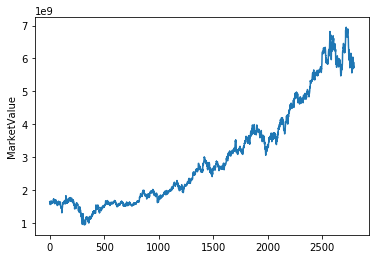

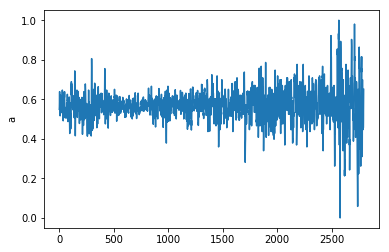

In [25]:
#正規化區域

Nor_Price = MinMaxNormalization(Nor_Price)
Nor_Price = [ (f-adjust_price_quantity)*2  for f in Nor_Price]

Nor_Quantity = MinMaxNormalization(Nor_Quantity)
Nor_Quantity = [(f- adjust_price_quantity)*2 for f in Nor_Quantity]



#Price_a,Price_a_min,Price_a_max = DeExtremeValue(Price_a)


Price_a_max = np.max(Price_a)
Price_a_min = np.min(Price_a)

if a_Normalization:
    Price_a = MinMaxNormalization(Price_a)

#issued_shares = MinMaxNormalization(issued_shares)
#Price_a,_,_ = DeExtremeValue(Price_a)
assert len(Nor_Price) == len(issued_shares)
#Price = MinMaxNormalization(Price)


TaxValue = [ f*0.03 for f in TaxValue]
TaxValue = MinMaxNormalization(TaxValue)

print(MarketValue[0])
plt.plot(MarketValue)
plt.ylabel('MarketValue')
plt.show()

MarketValue = MinMaxNormalization(MarketValue)
MarketValue = [ (f+1)/2 for f in MarketValue]

plt.plot(Price_a)
plt.ylabel('a')
plt.show()



In [26]:
Price_a[0]

0.549514563106796

In [27]:
#assert len(Nor_Price) == len(Nor_Quantity) == len(MarketValue)== len(Price_a)==len(issued_shares)==len(TaxValue)


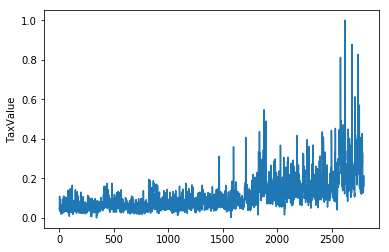

In [28]:
plt.plot(TaxValue)
plt.ylabel('TaxValue')
plt.show()
#MarketValue = [f+0.1 for f in MarketValue]

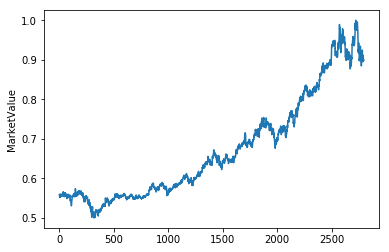

In [29]:
plt.plot(MarketValue)
plt.ylabel('MarketValue')
plt.show()
#MarketValue = [f+0.1 for f in MarketValue]

In [30]:
print(len(Price_a),len(Nor_Price),len(Nor_Quantity),len(MarketValue))

2796 2826 2826 2796


2796 2826 2826


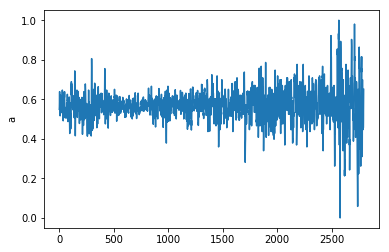

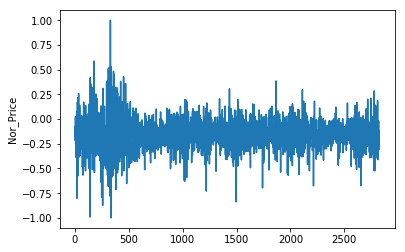

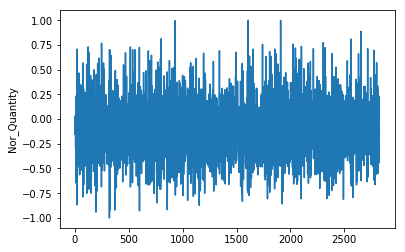

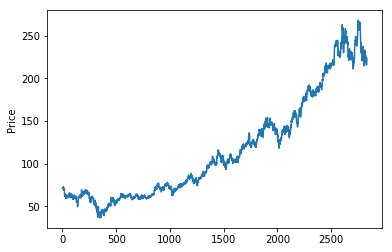

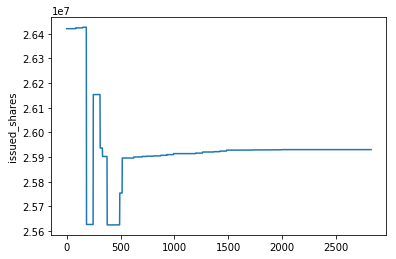

In [31]:
print(len(Price_a),len(Nor_Price),len(Nor_Quantity))

plt.plot(Price_a)
plt.ylabel('a')
plt.show()

plt.plot(Nor_Price)
plt.ylabel('Nor_Price')
plt.show()

plt.plot(Nor_Quantity)
plt.ylabel('Nor_Quantity')
plt.show()

plt.plot(Price)
plt.ylabel('Price')
plt.show()


plt.plot(issued_shares)
plt.ylabel('issued_shares')
plt.show()



In [32]:
len(issued_shares)
#正規化後少一天
#issued_shares = issued_shares[1:]

2826

In [33]:
len(Price_a)

2796

In [34]:
print(len(Price_a) , len(Nor_Price) )

2796 2826


In [35]:
Price_a  = [[f] for f in Price_a]
MarketValue = [[f] for f in MarketValue]
TaxValue =[[f] for f in TaxValue]



In [36]:
Nor_Quantity = SlidingWindow(Nor_Quantity,INPUT_SIZE)
#test_nor_Quantity = SlidingWindow(test_nor_Quantity,INPUT_SIZE)

Nor_Price = SlidingWindow(Nor_Price,INPUT_SIZE)
#test_nor_Price = SlidingWindow(test_nor_Price,INPUT_SIZE)

issued_shares = SlidingWindow(issued_shares,INPUT_SIZE)


In [37]:
print(len(Nor_Price) , len(Nor_Quantity) , len(MarketValue), len(Price_a),len(issued_shares),len(TaxValue))
#assert len(Nor_Price) == len(Nor_Quantity) == len(MarketValue)== len(Price_a)==len(issued_shares)==len(TaxValue)

# choic_tunnel_indice = np.random.choice((len(Nor_Quantity)),3,replace=False)
# print(choic_tunnel_indice)
# original_len = len(Nor_Price)

# def slice_tunnel(data,indices):
#     original_data = np.array(data).tolist()
#     data = np.array(data).tolist()
#     tunnel_datas = []
    
#     tunnel_len = 0
#     for i in range(len(indices)):
#         index = indices[i]
        
#         tunnnel_data = data[index:index+30]
#         tunnel_len+=len(tunnnel_data)
#         print(len(tunnnel_data))
#         tunnel_datas.append(tunnnel_data)
        
#     data = [f for index,f in enumerate(original_data) if index not in range(indices[0],indices[0]+30) and index not in range(indices[1],indices[1]+30) and index not in range(indices[2],indices[2]+30)]
#     print(len(data),len(original_data))
#     assert tunnel_len + len(data) == len(original_data)
    
    
#     return tunnel_datas,data
# tunnel_Nor_Price,Nor_Price = slice_tunnel(Nor_Price,choic_tunnel_indice)
# tunnel_Nor_Quantity,Nor_Quantity = slice_tunnel(Nor_Quantity,choic_tunnel_indice)
# tunnel_MarketValue,MarketValue = slice_tunnel(MarketValue,choic_tunnel_indice)
# tunnel_Price_a,Price_a = slice_tunnel(Price_a,choic_tunnel_indice)
# tunnel_issued_shares,issued_shares = slice_tunnel(issued_shares,choic_tunnel_indice)
# tunnel_TaxValue,TaxValue = slice_tunnel(TaxValue,choic_tunnel_indice)
# #取正負 方便以後預測
# #positve_a_index = [index for index,f in  enumerate( Price_a) if f >=0]
# #negative_a_index = [index for index,f in  enumerate( Price_a) if f <0]

# _,oringinal_Price_a  = slice_tunnel(oringinal_Price_a,choic_tunnel_indice)
# oringinal_Price_a = np.array(oringinal_Price_a)
# oringinal_Price_a = np.reshape(oringinal_Price_a,[-1])
# oringinal_Price_a = oringinal_Price_a.tolist()

# positve_a_index = [index for index,f in  enumerate( oringinal_Price_a) if f >=0]
# negative_a_index = [index for index,f in  enumerate( oringinal_Price_a) if f <0]
# print(len(positve_a_index) , len(negative_a_index) , len(Nor_Price))
# assert len(positve_a_index) + len(negative_a_index) == len(Nor_Price)

2796 2796 2796 2796 2796 2796


In [38]:
np.array(issued_shares).shape

(2796, 30)

' ## Slice Data

In [39]:
Price_a[0]

[0.549514563106796]

## Build CNN layers

In [40]:
def build_resnet_block(inputres, dim, name="resnet", padding="REFLECT"):
    """build a single block of resnet.
    :param inputres: inputres
    :param dim: dim
    :param name: name
    :param padding: for tensorflow version use REFLECT; for pytorch version use
     CONSTANT
    :return: a single block of resnet.
    """
    with tf.variable_scope(name):
        out_res = tf.pad(inputres, [[0, 0], [1, 1], [
            1, 1], [0, 0]], padding)
        out_res =general_conv2d(
            out_res, dim, 3, 3, 1, 1, 0.02, "VALID", "c1")
        out_res = tf.pad(out_res, [[0, 0], [1, 1], [1, 1], [0, 0]], padding)
        out_res = general_conv2d(
            out_res, dim, 3, 3, 1, 1, 0.02, "VALID", "c2", do_relu=False)

        return tf.nn.relu(out_res + inputres)
def highway(inputs,inputm, size, activation, carry_bias=-1.0):
    
    W_T = tf.Variable(tf.truncated_normal([size, size], stddev=0.1), name="weight_transform")
    b_T = tf.Variable(tf.constant(carry_bias, shape=[size]), name="bias_transform")

    W = tf.Variable(tf.truncated_normal([size, size], stddev=0.1), name="weight")
    b = tf.Variable(tf.constant(0.1, shape=[size]), name="bias")

    T = tf.sigmoid(tf.matmul(x, W_T) + b_T, name="transform_gate")
    H = activation(tf.matmul(x, W) + b, name="activation")
    C = tf.sub(1.0, T, name="carry_gate")

    y = tf.add(tf.mul(H, T), tf.mul(x, C), "y")
    
    return y

    
def lrelu(x, leak=0.2, name="lrelu", alt_relu_impl=False):

    with tf.variable_scope(name):
        if alt_relu_impl:
            f1 = 0.5 * (1 + leak)
            f2 = 0.5 * (1 - leak)
            return f1 * x + f2 * abs(x)
        else:
            return tf.maximum(x, leak * x)


def instance_norm(x):
    #樣本內標準化
    with tf.variable_scope("instance_norm"):
        epsilon = 1e-5
        mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
        scale = tf.get_variable('scale', [x.get_shape()[-1]],
                                initializer=tf.truncated_normal_initializer(
                                    mean=1.0, stddev=0.02
        ))
        offset = tf.get_variable(
            'offset', [x.get_shape()[-1]],
            initializer=tf.constant_initializer(0.0)
        )
        out = scale * tf.div(x - mean, tf.sqrt(var + epsilon)) + offset

        return out
    
def general_conv2d(inputconv, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02,
                   padding="VALID", name="conv2d", do_norm=True, do_relu=True,
                   relufactor=0):
    with tf.variable_scope(name):
        
        conv = tf.contrib.layers.conv2d(
            inputconv, #input
            o_d, #num_outputs
            f_w, #kernel_size
            s_w, #stride=1
            padding,#padding='SAME'
            activation_fn=None,
            weights_initializer=tf.truncated_normal_initializer(
                stddev=stddev
            ),
            biases_initializer=tf.constant_initializer(0.0)
        )
        if do_norm:
            conv = instance_norm(conv)

        if do_relu:
            if(relufactor == 0):
                conv = tf.nn.relu(conv, "relu")
            else:
                conv = lrelu(conv, relufactor, "lrelu")

        return conv


def general_deconv2d(inputconv
                     , o_d=100
                     , f_h=1
                     , f_w=3
                     , s_h=1
                     , s_w=1,
                     stddev=0.02
                     , padding="VALID"
                     , name="deconv2d",
                      do_relu=True, relufactor=0):
    """
    inputs,
    num_outputs,
    kernel_size,
    stride=1,
    padding='SAME',
    """
    with tf.variable_scope(name):

        conv = tf.contrib.layers.conv2d_transpose(
            inputconv
            ,o_d
            ,[f_h, f_w],
            [s_h, s_w]
            , padding
            ,activation_fn=None
            ,weights_initializer=tf.truncated_normal_initializer(stddev=stddev)
            ,biases_initializer=tf.constant_initializer(0.0)
        )

       

        if do_relu:
            if(relufactor == 0):
                conv = tf.nn.relu(conv, "relu")
            else:
                conv = lrelu(conv, relufactor, "lrelu")

        return conv

In [41]:

max_time = 2# 0&1

def discriminator_tf(inputdisc, name="discriminator",reuse=False):
    with tf.variable_scope(name,reuse=reuse):
        f = 4
        
        o_c1 = general_conv2d(inputdisc, OUTPUT_SIZE, f, f, 2, 2,
                                     0.02, "SAME", "c1", do_norm=False,
                                     relufactor=0.2)
        o_c2 = general_conv2d(o_c1, ndf * 2, f, f, 2, 2,
                                     0.02, "SAME", "c2", relufactor=0.2)
        
        o_c3 = general_conv2d(o_c2, ndf * 4, f, f, 2, 2,
                                     0.02, "SAME", "c3", relufactor=0.2)
        o_c4 =general_conv2d(o_c3, ndf * 8, f, f, 1, 1,
                                     0.02, "SAME", "c4", relufactor=0.2)
        o_c5 = general_conv2d(
            o_c4, 1, f, f, 1, 1, 0.02,
            "SAME", "c5", do_norm=False, do_relu=False
        )
        ##一般CNN
        ## 64
        ## 128
        ## 256
        ## 512
        ## 1
        return o_c5
    

def Generator(input,name='Generator',reuse=False):
    G_l1 = tf.layers.dense(input, 128,name =name+'_GL1',reuse=reuse,use_bias=True)
    G_l2 = tf.layers.dense(G_l1, 256,name = name+'_GL2',reuse=reuse,use_bias=True)
    G_l3 = tf.layers.dense(G_l2, 512,name = name+'_GL3',reuse=reuse,use_bias=True)
    G_out = tf.layers.dense(G_l3, OUTPUT_SIZE,tf.nn.sigmoid,name = name+'_Gout',reuse=reuse,use_bias=True)
    return G_out
def Discriminator(input,name='Discriminator',reuse=False):
    
    D_l = tf.layers.dense(input, 128, name=name+'_DL1',reuse=reuse,use_bias=True)
    D_l= tf.layers.dense(D_l, 256,tf.nn.relu, name=name+'_DL2',reuse=reuse,use_bias=True)
    D_l = tf.layers.dense(D_l, 512, name=name+'_DL3',reuse=reuse,use_bias=True)
    
    D_l = tf.layers.dense(D_l, 1, tf.nn.sigmoid, name=name+'_DOUT',reuse=reuse,use_bias=True)
    return D_l

Batch_shape = -1

def Discriminator_cnn(input,name='Discriminator_cnn',reuse=False,_OUTPUT_SIZE=OUTPUT_SIZE):
    with tf.variable_scope(name,reuse=reuse):
        f = ( math.sqrt(OUTPUT_SIZE) )
        if float(int(f)) != f:
            print('not square shape')
            f2 = (int(f)+1) * (int(f)+1)
            print(f,int(f),f2)
            f3 = f2 - OUTPUT_SIZE
            paddings = tf.constant([[0,0], [0,f3]])
            input = tf.pad(input,paddings,"CONSTANT")
            f = int(math.sqrt(f2) )
        f = int((f ) )
        print('f,OUTPUT_SIZE',f,OUTPUT_SIZE)
        ndf = _OUTPUT_SIZE
       
        input = tf.reshape(input,[Batch_shape,f,f,1],name='Discriminator_reshape')

        o_c1 = general_conv2d(input, ndf, f, f, 2, 2,
                                             0.02, "SAME", "c1", do_norm=False,
                                             relufactor=0.2)
        o_c2 = general_conv2d(o_c1, ndf * 2, f, f, 2, 2,
                                             0.02, "SAME", "c2", relufactor=0.2)
        o_c3 = general_conv2d(o_c2, ndf * 4, f, f, 2, 2,
                                             0.02, "SAME", "c3", relufactor=0.2)
        o_c4 =general_conv2d(o_c3, ndf * 8, f, f, 1, 1,
                                             0.02, "SAME", "c4", relufactor=0.2)
        o_c5 = general_conv2d(
                    o_c4, 1, f, f, 1, 1, 0.02,
                    "SAME", "c5", do_norm=False, do_relu=False)

        o_c6 = tf.reshape(o_c5,[Batch_shape,1])    
        return o_c6

def Generator_lstm(input,name='Generator_lstm',reuse=False):
    #24,5
    
    input = tf.reshape(input,[Batch_shape,OUTPUT_SIZE,1],name='Generator_reshape')
    #[1,120]
    INPUT_HIDDEN_SIZE = 64
 
    #print('BEFORE LSTM',input.shape)
     # X_in ==> (128 batches, 28 steps, 128 hidden) 换回3维
    hidden_size = 64
    keep_prob =0.8
    
    num_units = [hidden_size for _ in range(0,OUTPUT_SIZE)]
    
    cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n,forget_bias=0.8,name=name+'%d'%n,reuse=reuse,state_is_tuple=True) for n in num_units]
    stacked_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    init_state = stacked_rnn_cell.zero_state(BATCH_SIZE, dtype=tf.float32)
    outputs, final_state  = tf.nn.dynamic_rnn(stacked_rnn_cell, inputs=input, initial_state=init_state, time_major=False)
    
    outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
        
    print(outputs[-1])
        
    results = tf.layers.dense(outputs[-1], OUTPUT_SIZE,reuse=reuse,use_bias=True,activation=None)
    
    return results

def Generator_resnet(input, name="generator",reuse=False,resnet_num = 9):
    
    with tf.variable_scope(name,reuse=reuse):
        f = ( math.sqrt(OUTPUT_SIZE) )
        if float(int(f)) != f:
            print('not square shape')
            f2 = (int(f)+1) * (int(f)+1)
            print(f,int(f),f2)
            f3 = f2 - OUTPUT_SIZE
            paddings = tf.constant([[0,0], [0,f3]])
            input = tf.pad(input,paddings,"CONSTANT")
            f = (math.sqrt(f2) )
        print('f,OUTPUT_SIZE',f,OUTPUT_SIZE)
        f = ( int(f) )
        ngf = OUTPUT_SIZE*2
        
        input = tf.reshape(input,[Batch_shape,f,f,1],name='Generator_reshape')
        
        ks = 3
        padding = "REFLECT"
        
        pad_input = tf.pad(input, [[0, 0], [ks, ks], [
            ks, ks], [0, 0]], padding)
        o_c1 = general_conv2d(
            pad_input, ngf, f, f, 1, 1, 0.02, name="c1")
        o_c2 = general_conv2d(
            o_c1, ngf * 2, ks, ks, 2, 2, 0.02, "SAME", "c2")
        o_c3 = general_conv2d(
            o_c2, ngf * 4, ks, ks, 2, 2, 0.02, "SAME", "c3")
        ###32
        ###64
        ###128
        o_r1 = build_resnet_block(o_c3, ngf * 4, "r1", padding)
        
        for i in range(resnet_num-1):
            o_r1 = build_resnet_block(o_r1, ngf * 4, "r%d"%(i+2), padding)
        """
        [(W−F+2P)/S+1]
        w:width 
        F:Filter size
        P:padding (符合 n*n)
        S:stride size
        """
        
        """
        inputconv
        , o_d=100
                     , f_h=1
                     , f_w=3
                     , s_h=1
                     , s_w=1,
                     stddev=0.02
                     , padding="VALID"
                     , name="deconv2d",
                      do_relu=True, relufactor=0
        """
        
        _BATCH_SIZE,_f,_f,_num = o_r1.shape
        o_r1 = tf.reshape(o_r1,[-1,_f*_f*_num])
        print(o_r1.shape)
        
        out_gen = tf.layers.dense(o_r1, OUTPUT_SIZE,reuse=False,use_bias=True,activation=tf.nn.tanh)
        
        #out_gen = tf.nn.tanh(o_c6, "t1")
        #tf.layers.dense(Encoder, 1,reuse=False,use_bias=True,activation=tf.nn.tanh)
        #out_gen = tf.reshape(out_gen,[Batch_shape,OUTPUT_SIZE])
        print(out_gen.shape)
        return out_gen

In [42]:
# 5 => 6
#
G_price_in = tf.placeholder(tf.float32, [BATCH_SIZE, OUTPUT_SIZE],name='Nor_Price_in')          # random ideas (could from normal distribution)
F_quanilty_in = tf.placeholder(tf.float32, [BATCH_SIZE,OUTPUT_SIZE],name='Nor_quanilty_in')   # receive art work from the famous artist

price_in = tf.placeholder(tf.float32, [BATCH_SIZE, OUTPUT_SIZE],name='Price_in') 
quanilty_in = tf.placeholder(tf.float32, [BATCH_SIZE,OUTPUT_SIZE],name='quanilty_in')   # receive art work from the famous artist

lr = tf.placeholder(tf.float32,name='lr_in')

In [43]:
#G : convert price to quanilty

# if lstm:
#     G_out =  Generator_lstm(G_price_in,name='G_G')
#     F_out =  Generator_lstm(F_quanilty_in,name='F_G')

#     G_out_F_out = Generator_lstm(G_out,'F_G',reuse=True)
#     F_out_G_out = Generator_lstm(F_out,'G_G',reuse=True)  

# # else:
G_out =  Generator_resnet(G_price_in,name='G_G')
F_out =  Generator_resnet(F_quanilty_in,name='F_G')

G_out_F_out = Generator_resnet(G_out,'F_G',reuse=True)
F_out_G_out = Generator_resnet(F_out,'G_G',reuse=True)  



not square shape
5.477225575051661 5 36
f,OUTPUT_SIZE 6.0 30
(100, 960)
(100, 30)
not square shape
5.477225575051661 5 36
f,OUTPUT_SIZE 6.0 30
(100, 960)
(100, 30)
not square shape
5.477225575051661 5 36
f,OUTPUT_SIZE 6.0 30
(100, 960)
(100, 30)
not square shape
5.477225575051661 5 36
f,OUTPUT_SIZE 6.0 30
(100, 960)
(100, 30)


In [44]:
print(G_out.shape)
print(G_price_in.shape)

(100, 30)
(100, 30)


In [45]:
###resnet
Price_real_prob = Discriminator_cnn(G_price_in,name='P_D')
Price_fake_prob = Discriminator_cnn(F_out,name='P_D',reuse=True)

Quanilty_real_prob = Discriminator(F_quanilty_in,name='Q_D')
Quanilty_fake_prob = Discriminator(G_out,name='Q_D',reuse=True)

not square shape
5.477225575051661 5 36
f,OUTPUT_SIZE 6 30
not square shape
5.477225575051661 5 36
f,OUTPUT_SIZE 6 30


In [46]:
tvars = tf.trainable_variables()
F_G_vars = [var for var in tvars if 'F_G' in var.name]
G_G_vars = [var for var in tvars if 'G_G' in var.name]
P_D_vars = [var for var in tvars if 'P_D' in var.name]
Q_D_vars = [var for var in tvars if 'Q_D' in var.name]


In [47]:
all_cycle_vars = F_G_vars + G_G_vars + P_D_vars + Q_D_vars 

In [48]:
###resnet
Backward_F1_cycle_loss = tf.reduce_mean( tf.square(( (G_price_in) - (G_out_F_out) ) ) )
Foward_G1_cycle_loss =tf.reduce_mean( tf.square(( F_quanilty_in - (F_out_G_out) ) ) )

cyc_loss = Backward_F1_cycle_loss + Foward_G1_cycle_loss

G_loss = tf.reduce_mean(tf.square(((1-Quanilty_fake_prob))))+3*cyc_loss
F_loss = tf.reduce_mean(tf.square((1-Price_fake_prob))) + 3*cyc_loss

P_D_loss = tf.square(1-Price_real_prob) + tf.square(Price_fake_prob)
Q_D_loss = tf.square(1-Quanilty_real_prob) + tf.square(Quanilty_fake_prob)


In [49]:
train_F= tf.train.AdamOptimizer(lr).minimize(F_loss, var_list=F_G_vars)
train_G = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=G_G_vars)

train_Price_D = tf.train.AdamOptimizer(lr).minimize(P_D_loss, var_list=P_D_vars)
train_Quanilty_D = tf.train.AdamOptimizer(lr).minimize(Q_D_loss, var_list=Q_D_vars)

train_Generator = [train_F,train_G]
train_Discriminator = [train_Price_D,train_Quanilty_D]

In [50]:

#前一天漲幅

previous_gain_in = G_price_in[:,OUTPUT_SIZE-1]

# -7%~ +7%
K =   1

Reverse_F = K * previous_gain_in


m_in = tf.placeholder(dtype=tf.float32,shape=[BATCH_SIZE,1],name='MarketValue_in')#issue_shares_in*price_in



a_in = tf.placeholder(dtype=tf.float32,shape=[BATCH_SIZE,1],name='a')

tax_in = tf.placeholder(dtype=tf.float32,shape=[BATCH_SIZE,1],name='tax_in')





In [51]:

Reverse_F = tf.reshape(Reverse_F,[-1,1])


In [52]:

s_Friction = tf.Variable(dtype=tf.float32,initial_value =0.05,name='static_Friction')

Friction = tax_in


#M= tf.reshape(M,[-1,1])
print(Friction.shape)
print(m_in.shape)



(100, 1)
(100, 1)


In [53]:
"""tf.pad
paddings:[補充row,補充col],[往左多生幾個],[往右多生幾個]
padding = "REFLECT" 沒有值就用類似鏡面的方法產生

"""
Price_a[0]


[0.549514563106796]

In [54]:

def build_resnet_9blocks_tf2(input, name="generator",reuse=False,resnet_num=10):
    
    with tf.variable_scope(name,reuse=reuse):
        f = int( math.sqrt(OUTPUT_SIZE) )
        ngf = 32
        #input = tf.reshape(input,[BATCH_SIZE,f,f,1])
        
        ks = 2
        padding = "REFLECT"
       
        #RESHAPE
       
        o_c1 = general_conv2d(
            input, ngf, f, f, 1, 1, 0.02, name="c1")
        o_c2 = general_conv2d(
            o_c1, ngf * 2, ks, ks, 1, 1, 0.02, "SAME", "c2")
        o_c3 = general_conv2d(
            o_c2, ngf * 4, ks, ks, 1, 1, 0.02, "SAME", "c3")
        ###32
        ###64
        ###128
        o_r1 = build_resnet_block(o_c3, ngf * 4, "r0", padding)
        for i in range(resnet_num-1):
            o_r1 = build_resnet_block(o_r1, ngf * 4, "r%d"%(i+2), padding)
        
            
        """
        [(W−F+2P)/S+1]
        w:width 
        F:Filter size
        P:padding (符合 n*n)
        S:stride size
        """
        
        """
        inputconv
        , o_d=100
                     , f_h=1
                     , f_w=3
                     , s_h=1
                     , s_w=1,
                     stddev=0.02
                     , padding="VALID"
                     , name="deconv2d",
                      do_relu=True, relufactor=0
        """
#         o_c4 = general_deconv2d(
#             o_r1
#             #, [BATCH_SIZE, 128, 128, ngf * 2]
#             , ngf * 2, ks, ks, 2, 2, 0.02,
#             "SAME", "c4")
#         o_c5 = general_deconv2d(
#             o_c4
#             #, [BATCH_SIZE, 256, 256, ngf]
#             , ngf, ks, ks, 2, 2, 0.02,
#             "SAME", "c5")
#         o_c6 = general_conv2d(o_c5
#                               #, IMG_CHANNELS
#                               ,1
#                               , 2
#                               , 2
#                               , 4
#                               , 4
#                               ,0.02
#                               , "SAME"
#                               , "c6",
#                                      do_norm=False, do_relu=False)
    
#         print(o_c6.shape)
        #_,_f,_,num = o_c6.shape
        
        #out_gen = tf.reshape(o_c6,[-1,_f*_f*num])
        _,_f,_,num = o_r1.shape
        out_gen = tf.reshape(o_r1,[-1,_f*_f*num])
        
        out_gen = tf.layers.dense(out_gen, 1,reuse=False,use_bias=True,activation=None)

        return out_gen
    
def Predict_lstm(input,name='Generator_lstm',reuse=False):
    #24,5
    label_num = 36
    with tf.variable_scope(name):
        #input = tf.reshape(input,[-1,OUTPUT_SIZE*BATCH_SIZE])#
        #[1,120]
        INPUT_HIDDEN_SIZE = 2

        
        hidden_size = 2
        keep_prob =0.8

        num_units = [hidden_size for _ in range(0,label_num)]

        cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n,forget_bias=0.3,reuse=reuse,state_is_tuple=True) for n in num_units]
        stacked_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
        init_state = stacked_rnn_cell.zero_state(BATCH_SIZE, dtype=tf.float32)
        outputs, final_state  = tf.nn.dynamic_rnn(stacked_rnn_cell, inputs=input, initial_state=init_state, time_major=False)

        print('output',outputs)
        
        outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
        
        print(outputs[-1])
        
        results = tf.layers.dense(outputs[-1], 1,reuse=reuse,use_bias=True,activation=tf.nn.leaky_relu)
        


        return results

In [55]:
if lstm:
    StockPriceFluctuation = (F_out)  - (G_price_in)
    QuantityFluctuation = (G_out) - (F_quanilty_in)
    
    SQ_Fluctation = tf.concat([StockPriceFluctuation, QuantityFluctuation],1)
    SQ_Fluctation = tf.reshape(SQ_Fluctation,[BATCH_SIZE,OUTPUT_SIZE,2])
   
    F = Predict_lstm(SQ_Fluctation,name="F_FORCE",reuse=False)
    print('???')
else:
    


 
    #32
    #8 * 4
    #6,6
    StockPriceFluctuation = (F_out)  - (G_price_in)
    #6,6
    QuantityFluctuation = (G_out) - (F_quanilty_in)

    _f = int (math.sqrt(OUTPUT_SIZE * 2))
    _f = _f+1
    f2 = _f * _f
    #7,7
    rear_f = int (_f / 2)
    
    print(rear_f)
    paddings = tf.constant([[0, 0], [0,1]])
    print(_f)
    
    #9 * 4 = 36
    #40 =>49
    #80 => 81
    if _f * rear_f < OUTPUT_SIZE:
        rear_f +=1
        _f +=1
        
    if OUTPUT_SIZE != _f * rear_f :
        print('rear_f,_f',rear_f,_f,OUTPUT_SIZE)
        F3 = _f * rear_f - OUTPUT_SIZE
        
        paddings = tf.constant([[0,0], [0,F3]])
        #補0使其SHAPE FIT下層輸入
        StockPriceFluctuation = tf.pad(StockPriceFluctuation,paddings,"CONSTANT")
        
        QuantityFluctuation = tf.pad(QuantityFluctuation,paddings,"CONSTANT")
        
        
    print(StockPriceFluctuation.shape)
    print(QuantityFluctuation.shape)
    StockPriceFluctuation = tf.reshape(StockPriceFluctuation,[-1,_f,rear_f])

    QuantityFluctuation = tf.reshape(QuantityFluctuation,[-1,_f,rear_f])


    SQ_Fluctation = tf.concat([StockPriceFluctuation, QuantityFluctuation],2)
    print(SQ_Fluctation.shape)
    F4 = _f - rear_f*2
    paddings = tf.constant([[0,0], [0,0],[0,F4]])
    SQ_Fluctation = tf.pad(SQ_Fluctation,paddings,"CONSTANT")
    SQ_Fluctation.shape

    SQ_Fluctation = tf.reshape(SQ_Fluctation,[-1,_f,_f,1])

    F = build_resnet_9blocks_tf2(SQ_Fluctation,name="F_FORCE",resnet_num=F_resnet_layers_num)

    

output Tensor("F_FORCE/rnn/transpose_1:0", shape=(100, 30, 2), dtype=float32)
Tensor("F_FORCE/unstack:29", shape=(100, 2), dtype=float32)
???


In [56]:
F.shape

TensorShape([Dimension(100), Dimension(1)])

In [57]:
def simulate_friction(F,Friction,K=1.2):
    
    condition = tf.less(F, K*Friction)
    
    duplicate_Friction = tf.tile([s_Friction],[BATCH_SIZE])
    duplicate_Friction = tf.reshape(duplicate_Friction,[BATCH_SIZE,1])
    
    n_F = tf.multiply(F,0.8)
    print(n_F.shape)
    #抵銷大部分力量
    #待測試
    #res = tf.where(condition, n_F, duplicate_Friction)
    res = tf.where(condition, F, duplicate_Friction)
    return res



In [58]:
#預估一個數值n
#使得output + n and output -n 可以讓大多數值在此通道內
#透過 tf.less(UpperBound,real_prcice)得出是否大於實際值
#透過 tf.less(real_price,LoweerBound)得出通道是否低於實際值
#將兩者結果 (0,1)矩陣 相臣，即可知道有誰在此範圍內
#Sum(結果) / Count(結果)知道大概幾%概括在裡面，並與目標概括機率做loss
#盡可能多做幾次實驗 60~ 80 

In [59]:
#d_Friction = tf.Variable(tf.float32,name='dynamic_Friction')
#s_Friction = tf.Variable(tf.float32,name='static_Friction')

if system_dynamic:
    a =  (F - Friction)/m_in - (Reverse_F/m_in ) 
else:
    a = F 

sd_f = simulate_friction(F,s_Friction)

sd_a = tf.nn.relu(F - sd_f)/m_in - (Reverse_F/m_in ) 

print(a.shape)

(100, 1)
(100, 1)


In [60]:
tvars = tf.trainable_variables()
F_FORCE_vars = [var for var in tvars if 'F_FORCE' in var.name]


In [61]:

Price_Predict_loss = tf.reduce_mean( tf.square( a  - a_in))

Price_Predict_loss_no_mean = tf.square( a  - a_in)

static_friction_loss = tf.reduce_mean( tf.abs( sd_a  - a_in))


#Quantity_Predict_loss =tf.square( Quantity_Predict_label_IN - Quantity_Movement)





In [62]:
train_P_label= tf.train.AdamOptimizer(lr).minimize(Price_Predict_loss,var_list = F_FORCE_vars)



train_static_friction = tf.train.AdamOptimizer(lr).minimize(static_friction_loss,var_list =[s_Friction])



#train_Q_label = tf.train.AdamOptimizer(lr).minimize(Quantity_Predict_loss, var_list=Q_label_vars)

In [63]:
def restore_ins(var_weights):
    vars_ins = []
    Update_vars = []
    
    for i in range(len(var_weights)) :
        name = var_weights[i].name
        name = name.replace("\\","_")
        name = name.replace(":","_")
        var_in = tf.placeholder(tf.float32,var_weights[i].shape,name=name)
        vars_ins.append(var_in)
        #print(var_weights[i],var_in)
        #print(type(var_weights[i]))
      
        Update_vars.append( tf.assign(var_weights[i],var_in))
    return vars_ins,Update_vars

In [64]:
def restore_weights(vars_ins,Update_vars,weights):
    #
    feed_dict = {}
    for i in range(len(weights)):
        #sess.run(tf.assign(F_FORCE_vars[i],weights[i]))
        #print('complete : %f'%(i/len(weights)))
        feed_dict [vars_ins[i]] = weights[i]
        #print('has value: ',vars_ins[i].name)
    sess.run(Update_vars,feed_dict)
        

In [65]:

def build_resnet_9blocks_tf3(input, name="generator",reuse=False,resnet_num=10):
    
    with tf.variable_scope(name,reuse=reuse):
        f = int( math.sqrt(OUTPUT_SIZE) )
        ngf = 32
        #input = tf.reshape(input,[BATCH_SIZE,f,f,1])
        
        ks = 2
        padding = "CONSTANT"
       
        #RESHAPE
       
        o_c1 = general_conv2d(
            input, ngf, f, f, 1, 1, 0.02, name="c1")
        o_c2 = general_conv2d(
            o_c1, ngf * 2, ks, ks, 1, 1, 0.02, "SAME", "c2")
        o_c3 = general_conv2d(
            o_c2, ngf * 4, ks, ks, 1, 1, 0.02, "SAME", "c3")
        ###32
        ###64
        ###128
        o_r1 = build_resnet_block(o_c3, ngf * 4, "r0", padding)
        for i in range(resnet_num-1):
            o_r1 = build_resnet_block(o_r1, ngf * 4, "r%d"%(i+2), padding)

        _,_f,_,num = o_r1.shape
        out_gen = tf.reshape(o_r1,[-1,_f*_f*num])
        
        out_gen = tf.layers.dense(out_gen, 1,reuse=False,use_bias=True,activation=tf.nn.leaky_relu)

        return out_gen

In [66]:
np.array(Price).shape

(2832,)

In [67]:
# _f = int (math.sqrt(OUTPUT_SIZE))

# G_price_2 = tf.reshape(G_price_in,[-1,_f,_f,1])

# std_in = tf.placeholder(dtype=tf.float32,shape=  [None,1],name='std_in')

# std =  build_resnet_9blocks_tf3(G_price_2,name="tunnel",resnet_num=100)

# tvars = tf.trainable_variables()
# tunnel_vars = [var for var in tvars if 'tunnel' in var.name]


# tunnel_loss =tf.reduce_mean( tf.square(std-std_in))

# train_tunnel= tf.train.AdamOptimizer(lr).minimize(tunnel_loss,var_list = tunnel_vars)

In [68]:
#tunnel
#看誰比較長
positve_a_index = [index for index,f in  enumerate( oringinal_Price_a) if f >=0]
negative_a_index = [index for index,f in  enumerate( oringinal_Price_a) if f <0]


In [69]:
years = []
for date in dates :
    y = date[:4]
    if y not in years:
        years.append(y)
print(years)

train = '2007','2008','2009','2010','2011','2012','2013','2014'
val = '2015','2016'
test = '2017','2018'
indices = []
val_indices = []
test_indices = []
for i in range(1,len(dates)):
    
    
    if dates[i][:4] in train:
        indices.append(i-1)
        
    if dates[i][:4] in val:
        val_indices.append(i-1)
        
    if dates[i][:4] in test:
        test_indices.append(i-1)
        
        
        
print(max(indices))
print(max(val_indices))
print(max(test_indices))

print(max(test_indices))
print(len(dates))
print(len(Nor_Price))


['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
1856
2341
2794
2794
2796
2796


In [70]:
data_len = len(negative_a_index) if len(negative_a_index)< len(positve_a_index) else len(positve_a_index)
#從正負直接挑一半一半。
Train_part_rate = 0.6
Validation_part_rate = 0.2

tunnel_part_choice = 30
def sliceApart(data,Train_part_rate,Val_part_rate,indices =[],val_indices=[],test_indices = []):
    
    if len(indices) == 0:
        train = '2007','2008','2009','2010','2011','2012','2013','2014'
        val = '2015','2016'
        test = '2017','2018'
        indices = []
        val_indices = []
        test_indices = []
        for i in range(1,len(dates)):
    
    
            if dates[i][:4] in train:
                indices.append(i-1)

            if dates[i][:4] in val:
                val_indices.append(i-1)

            if dates[i][:4] in test:
                test_indices.append(i-1)

    
    data = np.array(data).tolist()
    
    
    train_data = np.array(data)[indices]
    
    val_data = np.array(data)[val_indices]
    
    
    test_data = np.array(data)[test_indices]
    
    return train_data,val_data,test_data,indices,val_indices,test_indices

def retriveFromdata(_indices = []):
    if len(_indices) ==0:
        _Nor_Price,val_nor_Price,test_nor_Price,indices,val_indices,test_indices = sliceApart(Nor_Price,Train_part_rate,Validation_part_rate)

        _Nor_Quantity,val_nor_Quantity,test_nor_Quantity,_,_,_ = sliceApart(Nor_Quantity,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)
        _MarketValue,val_MarketValue,test_MarketValue,_,_,_ = sliceApart(MarketValue,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)
        _issued_shares,val_issued_shares,test_issued_shares,_,_,_ = sliceApart(issued_shares,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)
        _TaxValue,val_TaxValue,test_TaxValue,_,_,_ = sliceApart(TaxValue,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)
        
        _Price_a,val_Price_a,test_Price_a,_,_,_ = sliceApart(Price_a,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)

    else:
        indices,val_indices,test_indices = _indices[0],_indices[1],_indices[2]
        _Nor_Price,val_nor_Price,test_nor_Price,indices,val_indices,test_indices = sliceApart(Nor_Price,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)
        _Nor_Quantity,val_nor_Quantity,test_nor_Quantity,_,_,_ = sliceApart(Nor_Quantity,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)
        _MarketValue,val_MarketValue,test_MarketValue,_,_,_ = sliceApart(MarketValue,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)


        _Price_a,val_Price_a,test_Price_a,_,_,_ = sliceApart(Price_a,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)
        _issued_shares,val_issued_shares,test_issued_shares,_,_,_ = sliceApart(issued_shares,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)
        _TaxValue,val_TaxValue,test_TaxValue,_,_,_ = sliceApart(TaxValue,Train_part_rate,Validation_part_rate,indices,val_indices,test_indices)



    train_datas = _Nor_Price,_Nor_Quantity,_MarketValue,_Price_a,_TaxValue
    val_datas = val_nor_Price,val_nor_Quantity,val_MarketValue,val_Price_a,val_TaxValue
    test_datas = test_nor_Price,test_nor_Quantity,test_MarketValue,test_Price_a,test_TaxValue
    
    #all_datas = Nor_Price,Nor_Quantity
    cycle_val_datas =  val_nor_Price.tolist()+_Nor_Price.tolist(),val_nor_Quantity.tolist()+_Nor_Quantity.tolist()
    cycle_test_datas =test_nor_Price.tolist()+val_nor_Price.tolist()+ _Nor_Price.tolist(),test_nor_Quantity.tolist()+val_nor_Quantity.tolist()+_Nor_Quantity.tolist()
    return train_datas,val_datas,test_datas,indices,val_indices,test_indices,cycle_val_datas,cycle_test_datas


#train_All_Price,train_All_Quantity= all_datas
#for i in range(0,100):
    #print(np.array(train_data_nor_Price.NextTrain()).shape )

In [71]:
current_startindice = -1
current_end_indice = -1

            
def get_train_data(data,start_index):
    end = False
    datas = []
    end_index = start_index + BATCH_SIZE
    for i in range(len(data)):
        if end_index >= len(data[0]):
            d = np.array( data[i] )[start_index:]
            res_len = end_index - len(data[0])
            d2 = np.array( data[i] )[:res_len]
            
            d = d.tolist() + d2.tolist()
            end = True
            
        else:
            d = np.array( data[i] )[start_index:end_index]
        datas.append(d)
    if end:
        end_index = 0
        
    return datas,end,end_index

In [72]:
def test_cycle(train_data,display = 1):
    losses = []
    start_index = 0
    end = False
    while(not end):
        
        
        datas,end,start_index = get_train_data(train_data,start_index)
        
        p = datas[0]
        q = datas[1]
        
        
        feed_dict = {
                    G_price_in:p
                    ,F_quanilty_in:q
                    
        }
        _cyc_loss = sess.run(cyc_loss,feed_dict)
        #_cyc_loss = _cyc_loss[:Valid_len]
        losses.append(_cyc_loss)
    if display == 1:
        print(np.mean(losses))
    return np.mean(losses)

In [73]:
def train(times,train_data,val_data,train_type=1,demand_loss = -1):
    step = 0
    epoch = 200
    
    G_loss_nums = []
   

    F_loss_nums = []
  
   
    cyc_losses_nums = []
    average_cyc_loss = []
    percentages = []
    i=0
    pre_val_loss = math.inf
    for j in range(1,(times+1)):
        _lr = 0.0005 if j  < times/2 else 0.0003
        
        
        if demand_loss != -1:
            train_loss = test_cycle(train_data,display=-1)
            val_loss = test_cycle(val_data,display=-1)

            difference_loss = np.abs(train_loss - val_loss)

            sum_loss = val_loss + difference_loss
            print('sum loss',sum_loss,'train loss',train_loss,'val loss',val_loss)
            
            if sum_loss <= demand_loss:
                print('im ready to fight! ')
                print('epoch:%d'%j)
           
                plt.plot(G_loss_nums)
                plt.ylabel('G_loss')
                plt.show()

                plt.plot(F_loss_nums)
                plt.ylabel('F_loss')
                plt.show()

                plt.plot(cyc_losses_nums)
                plt.ylabel('cyc_loss')
                plt.show()
                _loss = test_cycle(train_data,display=-1)
                print('average train cyc loss:',_loss)
                print('average val  cyc loss:',val_loss)
                #train_label(300)
                print('epoch:%d end'%j)
                train_cycle_weights = sess.run(all_cycle_vars)
                return train_cycle_weights
        
        
        
       
        start_index = 0
        end = False
        G1_loss_num,F_loss_num,cyc_loss_num=0,0,0
        num = 0
        while(not end):
        #print(start_index)
            
            datas,end,start_index = get_train_data(train_data,start_index)
            p = datas[0]
            q = datas[1]
            

            

            feed_dict= {G_price_in:p, F_quanilty_in:q
                ,lr:_lr }

            sess.run(train_Discriminator,feed_dict)

            sess.run(train_Generator,feed_dict)

            train_loss = test_cycle(train_data,display=-1)
            val_loss = test_cycle(val_data,display=-1)

            difference_loss = np.abs(train_loss - val_loss)

            sum_loss = val_loss + difference_loss
            G1_loss_num += sess.run(G_loss,feed_dict=feed_dict)
            F_loss_num += sess.run(F_loss,feed_dict=feed_dict)
            cyc_loss_num += sess.run(cyc_loss,feed_dict=feed_dict)

            if pre_val_loss > sum_loss:
                train_cycle_weights = sess.run(all_cycle_vars)
                pre_val_loss = sum_loss

            num+=1
            #while end
            G1_loss_num,F_loss_num,cyc_loss_num = G1_loss_num/num,F_loss_num/num,cyc_loss_num/num
            print('val_loss',val_loss)

           
        
            G_loss_nums.append(G1_loss_num)
            F_loss_nums.append(F_loss_num)
            cyc_losses_nums.append(cyc_loss_num)
        
        
        
        if j % 100 == 0 :  # plotting
            #clear_output(wait=True)
            
            print('epoch:%d'%j)
           
            plt.plot(G_loss_nums)
            plt.ylabel('G_loss')
            plt.show()
            
            plt.plot(F_loss_nums)
            plt.ylabel('F_loss')
            plt.show()
            
            plt.plot(cyc_losses_nums)
            plt.ylabel('cyc_loss')
            plt.show()
            _loss = test_cycle(train_data)
            print('average cyc loss:',_loss)
            #train_label(300)
            print('epoch:%d end'%j)
            #test(sess)
    #end for 
        #if j %300 ==0:
            
    
    
    #save_path = saver.save(sess, store_path)
    return train_cycle_weights
        
        


In [74]:
##test_tunnel
def test_tunnel(train_data,indices,a=a,Bband = False,days = -1,std_n = 2,filename='',sell_signal_value = 0.8,buy_signal_value = 0.2):
    end =False
    start_index = 0
    
    real_prices = []
    predict_prices = []

    tunnel_tops = []
    tunnel_downs = []


    tunnel_in = []
    
    
    buy = []
    sell = []
    buy_signal = 0
    sell_signal = 0
    
    buy_indices = []
    sell_indices = []
    
    bought = False
    percent_b_indices = []
    _real_prices = []
    
    MSES = []
    while(not end):
        #print(start_index)


        datas,end,end_index = get_train_data(train_data,start_index)
        p = datas[0]
        q = datas[1]
        _m = datas[2]
        a_label = datas[3]
        _tax = datas[4]

        if end_index ==0:
            _end_index = start_index+BATCH_SIZE

            _indices = indices[start_index:]
            res_len = _end_index - len(train_data[0])
            _indices2 = np.array(indices)[:res_len]
            _indices = np.array(_indices).tolist() + _indices2.tolist()
            add_more = True
        else:
            _indices = indices[start_index:end_index]
            add_more = False

        start_index = end_index

        feed_dict = {
                    G_price_in:p
                    ,F_quanilty_in:q
                    ,m_in:_m
                    ,tax_in:_tax
        }

        #print(p)
        #print(p_label)
        _a = sess.run(a,feed_dict=feed_dict)
        
        #_std = sess.run(std,feed_dict=feed_dict)
        if add_more:
            a_label = a_label[:-res_len]
            _a = _a[:-res_len]



        #assert len(_a) == len(_std)
        #print(np.array(_a).shape,np.array(a_label).shape)
        stds = []
        
        for i in range(len(a_label)):
            #print('real a = ',a_label[i][0])
           
            if a_Normalization:
                real_a = DeNormalization_a(a_label[i][0],Price_a_max=Price_a_max,Price_a_min=Price_a_min)
                predict_a = DeNormalization_a(_a[i][0],Price_a_max=Price_a_max,Price_a_min=Price_a_min)
            else:
                real_a = (a_label[i][0])
                predict_a = (_a[i][0])
            
            #Real & Predict loss
            mse = np.square((real_a -predict_a ))
            MSES.append(mse)
            _index = _indices[i] #NorPrice index 

            #Price多第一天，故不取
            #第1~36天
            _last_prices = Price[_index+2:_index+2+OUTPUT_SIZE]
            
            if len(_last_prices)< days:
                res_len = days -len(_last_prices) 
                res_Price = Price[(_index+2 - res_len):_index+2]
                if _index+2 - res_len<0:
                    continue
                #print(len(res_Price),res_len)
                assert len(res_Price) == res_len
                _last_prices = res_Price + _last_prices
                assert len(_last_prices) == days
            
        
               
  
         
            #37天~41
            _prices_for_predict = Price[_index+1+OUTPUT_SIZE+1:_index+1+OUTPUT_SIZE+1+t]
            
            real_price = _prices_for_predict[-1]
            close_price = _prices_for_predict[0]
            
           

            #通道
            
            
            
            
            
            #assert len(_last_prices) == OUTPUT_SIZE
            assert len(_prices_for_predict) == t
            last_Price = _last_prices[-1]
            #最後一天價格
            real_price = _prices_for_predict[-1]

            #真實價格
            if system_dynamic:
                
                _real_price = restore_a(last_Price,real_a)
            
                predict_price = restore_a(last_Price,predict_a)
            else:
                _real_price = last_Price + real_a
                predict_price = last_Price +predict_a
                
            #print(_real_price,real_price)
            if not a_Normalization:
                assert _real_price == real_price
            else:
                _real_price = round(_real_price,1)
            
            #print(_real_price,real_price,predict_price)
            #print(real_a,predict_a)
            #assert _real_price == real_price
            if Bband:
#                 if days != -1:
#                     start_day = OUTPUT_SIZE - days
                    
#                     _last_prices = _last_prices[start_day:]
                    
                _ma = np.mean(_last_prices)
                _std = np.std(_last_prices)
                
                tunnel_top = _ma  + std_n* _std
                tunnel_down = _ma - std_n* _std
            else:
                #_last_prices = _last_prices
                _last_prices.append(predict_price)
                
                
                
                
#                 if days != -1:
#                     start_day = OUTPUT_SIZE - days
                    
#                     _last_prices = _last_prices[start_day:]
                    
                _ma = np.mean(_last_prices)
                _std = np.std(_last_prices)
               

                tunnel_top = _ma +  std_n* _std
                tunnel_down = _ma - std_n* _std
            
            
            #超出通道，股價漲跌幅
            
            #今日價格看是否5日後也是強勢價格
            percent_b_index = (close_price - tunnel_down) / (tunnel_top -  tunnel_down)
            percent_b_indices.append(percent_b_index)
            
            real_prices.append(real_price)
            
            if percent_b_index >= sell_signal_value:
                #sell
                sell_signal += 1 
                
                if len(sell) >= len(buy):
                    #不可能先賣
                    continue
                
                #print(predict_prices_trend_for_tunnel)
                #if bought == True:
                    #bought = False
                sell.append(close_price)
                sell_indices.append(len(real_prices)-1)
                
                
            elif percent_b_index <= buy_signal_value:
                #buy
                buy_signal += 1 
                #if bought == False:
                #bought = True
                    #print('date',dates[_index+1+OUTPUT_SIZE+1+t])
                buy.append(close_price)
                buy_indices.append(len(real_prices)-1)
                
   
    
    plt.plot(tunnel_tops,'g')
    
    plt.plot(real_prices,'r')
    plt.plot(predict_prices,'b')
    
    plt.plot(tunnel_downs,'g')
    plt.show()
    
    plt.plot(real_prices)
    plt.plot(predict_prices,'--')
    _filename = 'Trade_pic/'+filename+'_predict_stockprice.png'
    print(_filename)
    plt.savefig(_filename)
    trade_time = 0
    for i in range(len(buy_indices)):
        
        try:
            buy_indice = buy_indices[i]
            sell_indice = sell_indices[i]
        except:
            continue
        trade_time += 1
        pre_start_day = (buy_indice - 5)
        post_end_day = sell_indice+5
        prices_range = real_prices[pre_start_day:post_end_day]
        
        
        post = len(prices_range)-5
        markers_on = [5,post]
        
        plt.plot(prices_range,markevery=markers_on, marker='o')
        #plt.show()
        plt.savefig('Trade_pic/'+filename+'%d.png'%i)
        plt.close('all')
    print('trade_time',trade_time)
    print('buy signal ',buy_signal)
    print('sell signal',sell_signal)
    plt.plot(real_prices,'r')
    
    
    
    rates = []
    
    plt.plot()
    for i in range(len(sell)):
        try:
            r = (sell[i] - buy[i]) / buy[i]
            rates.append(r)
        except:
            break
    print('average rate return :',np.mean(rates))
        
    print('MSE Of a ,',np.mean(MSES))
    return rates,real_prices,MSES

In [75]:
##test
def test(train_data ,indices,a=a,display = 1):
    
    
    losses = []
    signs = []
    
    
    MSE = []
    
    num = 0
    tunnel_in_num = []
    
    top_tunnels = []
    down_tunnels = []
    
    top_limit_nums = []
    down_limit_nums = []

    TPS =[]
    TNS =[]
    FPS =[]
    FNS =[]
    
    start_index = 0
    end = False
    real_price_error = []
    while(not end):
        #print(start_index)
        
        
        datas,end,end_index = get_train_data(train_data,start_index)
        p = datas[0]
        q = datas[1]
        _m = datas[2]
        a_label = datas[3]
        _tax = datas[4]
        
        if end_index ==0:
            _end_index = start_index+BATCH_SIZE
            
            _indices = indices[start_index:]
            res_len = _end_index - len(train_data[0])
            _indices2 = np.array(indices)[:res_len]
            _indices = np.array(_indices).tolist() + _indices2.tolist()
            
        else:
            _indices = indices[start_index:end_index]
        start_index = end_index
       
        feed_dict = {
                    G_price_in:p
                    ,F_quanilty_in:q
                    ,m_in:_m
                    ,tax_in:_tax
                    ,a_in:a_label
        }
        
        #print(p)
        #print(p_label)
        _a = sess.run(a,feed_dict=feed_dict)
        mse_loss = sess.run(Price_Predict_loss,feed_dict=feed_dict)
        MSE.append(mse_loss)
        
       
        
        assert len(_a) == len(a_label)
        #print(np.array(_a).shape,np.array(a_label).shape)
        
        for i in range(len(a_label)):
            #print('real a = ',a_label[i][0])
            if a_Normalization:
                real_a = DeNormalization_a(a_label[i][0],Price_a_max=Price_a_max,Price_a_min=Price_a_min)
                predict_a = DeNormalization_a(_a[i][0],Price_a_max=Price_a_max,Price_a_min=Price_a_min)
            else:
                real_a = (a_label[i][0])
                predict_a = (_a[i][0])
            _index = _indices[i] #NorPrice index 
            #print(real_a,predict_a)
            #Price多第一天，故不取
            #第1~36天
            _last_prices = Price[_index+2:_index+2+OUTPUT_SIZE]
            #37天~41
            _prices_for_predict = Price[_index+1+OUTPUT_SIZE+1:_index+1+OUTPUT_SIZE+1+t]
            
            
            
            real_price = _prices_for_predict[-1]
            
            
            #assert _real_price == real_price
            
            assert len(_last_prices) == OUTPUT_SIZE
          
            
           
            
            #print(real_a,predict_a)
            _loss = np.abs(real_a - predict_a) 
            losses.append(_loss)
            
            last_Price = _last_prices[-1]
            
            if system_dynamic:
                _real_price = restore_a(last_Price,real_a)
            
                predict_price = restore_a(last_Price,predict_a)
            else:
                _real_price = last_Price + real_a
                predict_price = last_Price + predict_a
            
            if not a_Normalization:
                assert _real_price == real_price
            else:
                zzz = 1
                
            _real_price = round(_real_price,1)
            predict_price = round(predict_price,1)
            
            loss = np.abs(real_price-predict_price)
            real_price_error.append(loss)
        num += len(a_label)
        
    if display == 1:
       
        print('mse:',np.mean(MSE))

        #print('在tunnel的機率 ',  sum(tunnel_in_num)/ len(tunnel_in_num))

        print('平均差距',np.mean(losses))

        
        plt.plot(losses)
        plt.ylabel('losses')
        plt.show()
    
        print('平均股價差距',np.mean(real_price_error))
    return 0,0,np.mean(MSE)



In [76]:
mean_Price

116.17420550847457

In [77]:
#train_P_label= tf.train.AdamOptimizer(lr).minimize(Price_Predict_loss,var_list = F_FORCE_vars)

#train_static_friction = tf.train.AdamOptimizer(lr).minimize(static_friction_loss,var_list = [s_Friction])



In [78]:
def train_label(times,train_data,train_type = 1,LST = False):
    
    p_losses = []
    allp_losses = []
    q_losses = []
    a_losses = []
    fs = []
    SF = []
    
    accs = []
    losses = []
    scores = []
    train_losses = []
    for i in range(1,times+1):
        _lr = 0.0005
        if i >=150:
            _lr = 0.0003
        if i >= (times/2) :
            _lr = 0.0001
        num = 0
        p_loss = 0

        start_index = 0
        end = False
        while(not end):
            #print(start_index)

            datas,end,start_index = get_train_data(train_data,start_index)
            
            p = datas[0]
            q = datas[1]
            _m = datas[2]
            _a = datas[3]
            _tax = datas[4]  

            
            feed_dict = {G_price_in:p
                         ,F_quanilty_in:q
                        ,lr:_lr
                        ,a_in:_a   
                         ,m_in:_m
                        ,tax_in:_tax
                }

            sess.run([train_P_label],feed_dict=feed_dict)
            

            num+=1
        a_loss = sess.run(Price_Predict_loss,feed_dict)
        a_losses.append(a_loss)
           
        #訓練
        
        #losses.append(loss)
        print('current epoch:%d'%i)

        train_acc,train_recall,train_loss = test(train_datas,indices,display = 0)
        #train_losses.append(train_loss)
    
        val_accruacy,val_recall,val_loss = test(val_datas,val_indices,display = 0)

        score =(val_accruacy)#*0.6 + val_recall*0.4
        scores.append(score)
        acc = val_accruacy

        accs.append(acc)

        loss = ((val_loss))

        losses.append(loss)

        if  loss == np.min(losses):
            save_weights = sess.run(F_FORCE_vars)
            save_loss = loss
            print('better than before')
            #restore_weights(cycle_weights_in,update_cycle_weights,test_cycle_weights)
            #test(test_datas,test_indices)
                
        #restore_weights(cycle_weights_in,update_cycle_weights,train_cycle_weights)
        
        if i %100==0  :
            clear_output(wait=True)
            plt.plot(losses)
            plt.ylabel('val losses')
            plt.show()
            
            
    #allp_losses = np.reshape(allp_losses,[-1])
    #allp_losses = allp_losses[]
    plt.plot(accs)
    plt.ylabel('acc')
    plt.show()
    
    plt.plot(a_losses)
    plt.ylabel('train_loss')
    plt.show()
    
    plt.plot(losses)
    plt.ylabel('val losses ')
    plt.show()

    
    
    return save_weights,save_loss,p_losses

In [79]:
sess = tf.Session() 
sess.run(tf.global_variables_initializer())
plt.ion()   # something about continuous plotting


In [80]:
##用於還原nn的weight,助於測試結果

original_cycle_weights = sess.run(all_cycle_vars)


original_f_weights = sess.run(F_FORCE_vars)

#original_std_weights = sess.run(tunnel_vars)

cycle_weights_in,update_cycle_weights = restore_ins(all_cycle_vars)


f_weights_in,update_f_weights = restore_ins(F_FORCE_vars)

#std_weights_in,update_std_weights = restore_ins(tunnel_vars)

In [81]:
F.shape


TensorShape([Dimension(100), Dimension(1)])

In [82]:
#saver = tf.train.Saver()
#saver.save(sess,save_path='./36_0.8.cpgk')
accs = []
losses = []
t_accs = []
#
###回復原本的網路



In [83]:
restore_weights(cycle_weights_in,update_cycle_weights,original_cycle_weights)
restore_weights(Update_vars=update_f_weights,vars_ins=f_weights_in,weights=original_f_weights)


In [84]:
from datetime import datetime 
import time



In [85]:
# start_time = datetime.now() 
# # train(3000,train_datas,train_type=2,demand_loss=0.085)
# # train_cycle_weights = sess.run(all_cycle_vars)
# # time_elapsed = datetime.now() - start_time 

# print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

In [86]:
# np.savez('indices.npz', name1=indices)
# np.savez('val_indices.npz', name1=val_indices)
# np.savez('test_indices.npz', name1=test_indices)

# indices = np.load('indices.npz')['name1']
# val_indices = np.load('val_indices.npz')['name1']
# test_indices = np.load('test_indices.npz')['name1']
print(max(test_indices))

print(len(Nor_Price))
print(len(MarketValue))
print(len(Price_a))

2794
2796
2796
2796


In [87]:

# if load == True:
#     #讀 訓練 / 驗證 / 測試
    
#     train_datas,val_datas,test_datas,indices,val_indices,test_indices,cycle_val_datas,cycle_test_datas = retriveFromdata()
#     train_cycle_weights = np.load('train_cycle_weights_year.npz')['name1']
#     restore_weights(cycle_weights_in,update_cycle_weights,train_cycle_weights)
    
    


# else:
train_datas,val_datas,test_datas,indices,val_indices,test_indices,cycle_val_datas,cycle_test_datas = retriveFromdata()
    


train_data_nor_Price,train_data_nor_Quanility,train_data_MarketValue,train_data_Price_a,train_data_TaxValue=train_datas 
validation_data_nor_Price,validation_data_nor_Quanility,validation_data_MakertValue,validation_Price_a,validation_TaxValue=val_datas  
test_data_nor_Price,test_data_nor_Quanility,test_data_MarketValue,test_data_Price_a,test_data_TaxValue=test_datas


In [88]:

len(train_data_nor_Price),len(train_data_Price_a)

(1857, 1857)

In [89]:
# # train_cycle_weights = np.load('train_cycle_weights.npz')['name1']
# # restore_weights(cycle_weights_in,update_cycle_weights,train_cycle_weights)
# np.savez('train_cycle_weights_year.npz', name1=train_cycle_weights)

# np.savez('indices_year.npz', name1=indices)
# np.savez('val_indices_year.npz', name1=val_indices)
# np.savez('test_indices_year.npz', name1=test_indices)

# from scipy.misc import toimage
# #toimage(data).show()
# end = False
# start_index = 0
# datas,end,end_index = get_train_data(train_datas,start_index)
# ___price = datas[0]

# ___price = ___price[0]

# ___price = np.reshape(___price,[6,6,1])
# print(___price.shape)

# from PIL import Image
# # img = Image.fromarray(___price, 'RGB')
# # img.save('my.png')
# # img.show()

In [90]:
#train_cycle_weights = sess.run(all_cycle_vars)
# indices = np.load('indices_year.npz')['name1']
# val_indices = np.load('val_indices_year.npz')['name1']
# test_indices = np.load('test_indices_year.npz')['name1']

train_cycle_weights = np.load('train_cycle_weights_30_years.npz')['name1']
restore_weights(cycle_weights_in,update_cycle_weights,train_cycle_weights)

# train_cycle_weights = np.load('train_cycle_weights_year.npz')['name1']
# restore_weights(cycle_weights_in,update_cycle_weights,train_cycle_weights)


# np.savez('train_cycle_weights_temp.npz', name1=train_cycle_weights)
# # restore_weights(cycle_weights_in,update_cycle_weights,train_cycle_weights)

# np.savez('indices_temp.npz', name1=indices)
# np.savez('val_indices_temp.npz', name1=val_indices)
# np.savez('test_indices_temp.npz', name1=test_indices)
 

sum loss 0.01672499 train loss 0.016229397 val loss 0.016477194
im ready to fight! 
epoch:1


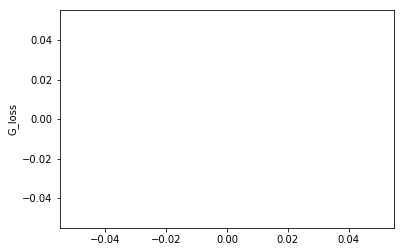

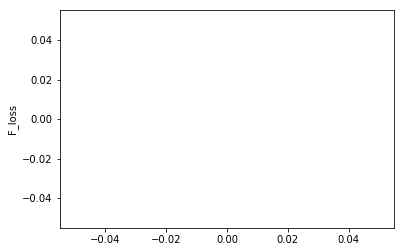

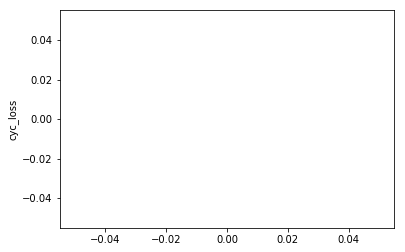

average train cyc loss: 0.016229397
average val  cyc loss: 0.016477194
epoch:1 end
0.016229397
0.016477194
0.015846474


In [91]:

if load == True:
    print('i''ve trained')
    #train_cycle_weights = train(1,train_datas,val_datas,train_type=2,demand_loss=0.03)
else:
    train_cycle_weights = train(1000,train_datas,val_datas,train_type=2,demand_loss=0.02)
#train_cycle_weights = sess.run(all_cycle_vars)

test_cycle(train_datas)
test_cycle(val_datas)
test_cycle(test_datas)


#
val_cycle_weights = test_cycle_weights = train_cycle_weights

# np.savez('train_cycle_weights_622.npz', name1=train_cycle_weights)
# np.savez('indices_622.npz', name1=indices)
# np.savez('val_indices_622.npz', name1=val_indices)
# np.savez('test_indices_622.npz', name1=test_indices)


In [92]:
#20天 cycle loss
#0.031995635
#0.038789876
#0.036866438
#30天
# 0.016229397
# 0.016477194
# 0.015846474
#40天
# 0.0015571207
# 0.031062838
# 0.030280465
#np.savez('train_cycle_weights_30_years.npz', name1=train_cycle_weights)

In [93]:
#np.savez('f_force_save_weight_year.npz', name1=save_weight)

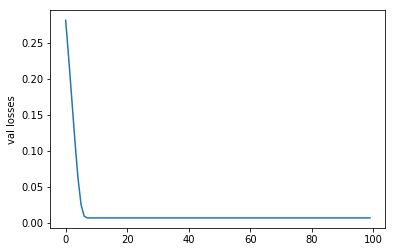

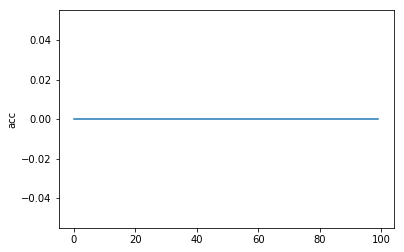

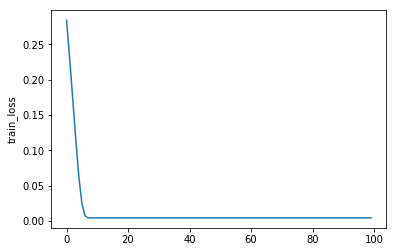

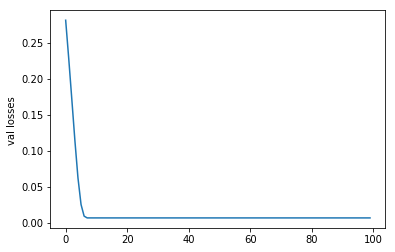

In [94]:
# if load and not lstm and  not a_Normalization:
#     save_weights = np.load('f_force_save_weight_year.npz')['name1']

#     restore_weights(Update_vars=update_f_weights,vars_ins=f_weights_in,weights=save_weights)
# elif load and not lstm and a_Normalization:
#     save_weights = np.load('f_force_resnet_normalized_year.npz')['name1']

#     restore_weights(Update_vars=update_f_weights,vars_ins=f_weights_in,weights=save_weights)
# else:
restore_weights(Update_vars=update_f_weights,vars_ins=f_weights_in,weights=original_f_weights)

if lstm:

    save_weight,save_loss,label_loss = train_label(100,train_datas,train_type=2,LST=False)
else:
    save_weight,save_loss,label_loss = train_label(500,train_datas,train_type=2,LST=False)


restore_weights(Update_vars=update_f_weights,vars_ins=f_weights_in,weights=save_weight)

#acc,loss,t_acc = test(test_datas,test_indices)
    


mse: 0.002683305
平均差距 1.9944982687344677


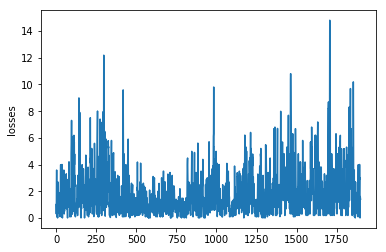

平均股價差距 1.9941842105263154
mse: 0.006459153
平均差距 3.3713420780301093


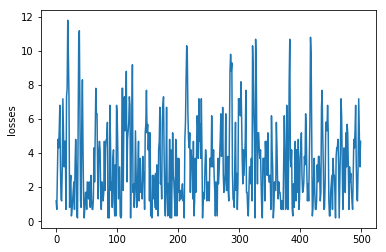

平均股價差距 3.371999999999999
mse: 0.018342443
平均差距 5.0776026732884345


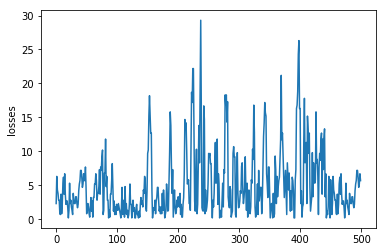

平均股價差距 5.077799999999999


In [95]:
train_acc,train_recall,train_loss = test(train_datas,indices)
        
    
    
val_accruacy,val_recall,val_loss = test(val_datas,val_indices)
test_accruacy,test_recall,test_loss = test(test_datas,test_indices)
# 30
# mse: 0.094973914
# mse: 0.14048794
# mse: 0.33454952

# 60
# mse: 0.12900639
# mse: 0.14866208
# mse: 0.32760862

#90
#mse: 0.0914509
#mse: 0.14604922
#mse: 0.33388183

#RESNET
# no system dynamic and no normalization
# mse: 6.897131
# 平均股價差距 1.9692368421052633
# mse: 17.15033
# 平均股價差距 3.36
# mse: 48.776146
# 平均股價差距 5.1042000000000005

# system dynamic and no Normalization
# mse: 0.10290454
# 平均股價差距 3.211394736842105
# mse: 0.16515777
# 平均股價差距 4.104
# mse: 0.33787745
# 平均股價差距 5.390599999999999

#system dynamic and Normalization

# mse: 0.14330134
# 平均股價差距 15.592605263157896
# mse: 0.05308482
# 平均股價差距 9.153
# mse: 0.0914881
# 平均股價差距 12.2104

#no system dynamic and Normalization
# mse: 0.0022944
# 平均股價差距 1.906973684210526
# mse: 0.009280657
# 平均股價差距 3.9997999999999996
# mse: 0.019344639
# 平均股價差距 5.3466000000000005


#lstm
#NO SYSTEM DYNAMIC AND NO NORMALIZATION
# mse: 7.111908
#平均股價差距 1.9952368421052635
#mse: 17.146702
#平均股價差距 3.380000000000001
#mse: 48.669594
#平均股價差距 5.0802000000000005

# #system dynamic and no normalization
# mse: 0.1389201
# 平均股價差距 3.518605263157895

# mse: 0.1398336
# 平均股價差距 3.7601999999999998
# mse: 0.33216518
# 平均股價差距 5.308799999999999

##system dynamic and normalization
# mse: 0.14330134
# 平均股價差距 15.592605263157896
# mse: 0.05308482
# 平均股價差距 9.153
# mse: 0.0914881
# 平均股價差距 12.2104

##no system dynamic and normalization
# mse: 0.0026814814
# 平均股價差距 1.9945526315789472
# mse: 0.00646579
# 平均股價差距 3.371999999999999
# mse: 0.018351346
# 平均股價差距 5.077799999999999

#system dynamic and normalization
# mse: 0.09410314
# 平均股價差距 11.243815789473684
# mse: 0.09882288

# 平均股價差距 13.5698
# mse: 0.17061481
# 平均股價差距 18.659800000000004

In [96]:

#np.savez('f_force_save_weight_year_30_40.npz', name1=save_weight)
lstm,a_Normalization,system_dynamic

(True, True, False)

In [97]:
# restore_weights(Update_vars=update_std_weights,vars_ins=std_weights_in,weights=original_std_weights)

# save_std_weights = train_std(train_data=train_datas,indices=indices,epoch = 20000)

# restore_weights(Update_vars=update_std_weights,vars_ins=std_weights_in,weights=save_std_weights)



In [98]:
# # # acc1,top1,down1,rate1 = test_tunnel(train_datas,indices=indices,Bband = True,days= 25)
# # # # acc2,top2,down2,rate2= test_tunnel(val_datas,indices=val_indices,Bband = True,days= 25)
# # # # acc3,top3,down3,rate3 = test_tunnel(test_datas,indices=test_indices,Bband = True,days= 25)
# rates = []
# # #0~21
# # #5~37
# # #0 5 1 6 26

# for i in (5,10,15,20,25,30,35):
    
#     rate1,top1,down1 = test_tunnel(train_datas,indices=indices,Bband = True,days= i,sell_signal_value=1,buy_signal_value=0)
#     rate2,top2,down2= test_tunnel(val_datas,indices=val_indices,Bband = True,days= i,sell_signal_value=1,buy_signal_value=0)
#     rate3,top3,down3 = test_tunnel(test_datas,indices=test_indices,Bband = True,days= i,sell_signal_value=1,buy_signal_value=0)
    
#     rate = rate1 + rate2 +rate3
#     #rate = rate3
#     average = np.mean(rate)
#     rates.append(average)
# print(np.argmax(rates))


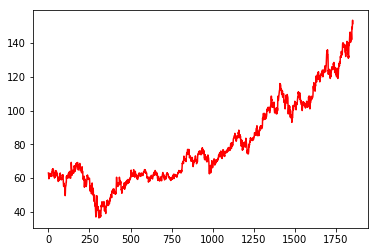

Trade_pic/BBand_Train_predict_stockprice.png
trade_time 93
buy signal  93
sell signal 183
average rate return : 0.14036186253460273
MSE Of a , 7.201630749051793


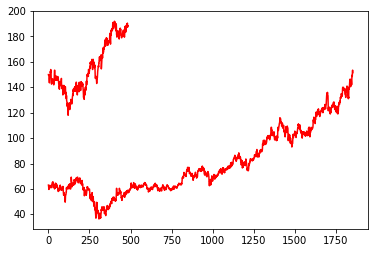

Trade_pic/BBand_val_predict_stockprice.png
trade_time 38
buy signal  38
sell signal 42
average rate return : 0.2070904763458869
MSE Of a , 17.122698807964074


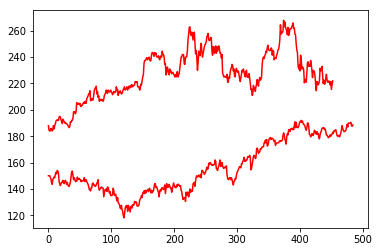

Trade_pic/BBand_test_predict_stockprice.png
trade_time 18
buy signal  25
sell signal 59
average rate return : 0.12120448154732534
MSE Of a , 52.07358949216138
all average return rate 0.15506558379002425


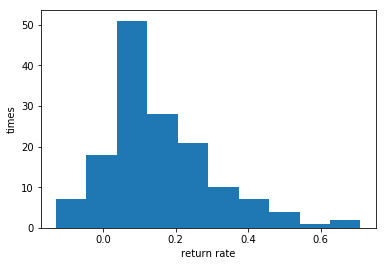

In [99]:
days = 35
rate1,_,_ = test_tunnel(train_datas,indices=indices,Bband = True,days= days,std_n=2,filename='BBand_Train',sell_signal_value=1,buy_signal_value=0)
rate2,_,_= test_tunnel(val_datas,indices=val_indices,Bband = True,days= days,std_n=2,filename='BBand_val',sell_signal_value=1,buy_signal_value=0)
rate3,_,_ = test_tunnel(test_datas,indices=test_indices,Bband = True,days= days,std_n=2,filename='BBand_test',sell_signal_value=1,buy_signal_value=0)




rate = rate1 + rate2 +rate3
average = np.mean(rate)
plt.close('all')
plt.hist(rate)
plt.xlabel('return rate')
plt.ylabel('times')
#plt.show()
plt.savefig('Trade_pic/BBand_average_return.png')

print('all average return rate',average)






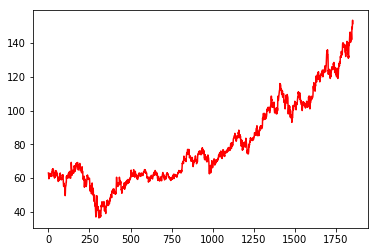

Trade_pic/LSTM_Train_predict_stockprice.png
trade_time 84
buy signal  84
sell signal 155
average rate return : 0.16136712937650405
MSE Of a , 7.201630749051793


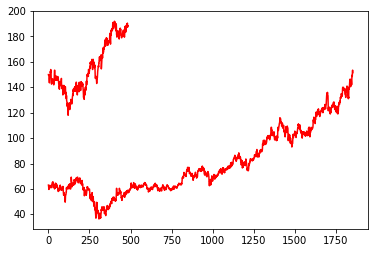

Trade_pic/LSTM_val_predict_stockprice.png
trade_time 31
buy signal  34
sell signal 33
average rate return : 0.2497622931293341
MSE Of a , 17.122698807964074


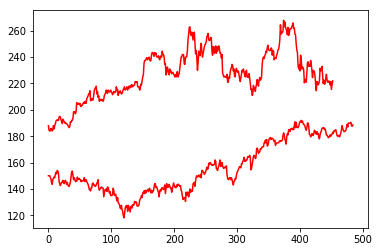

Trade_pic/LSTM_test_predict_stockprice.png
trade_time 17
buy signal  23
sell signal 44
average rate return : 0.12433106641198544
MSE Of a , 52.07358949216138


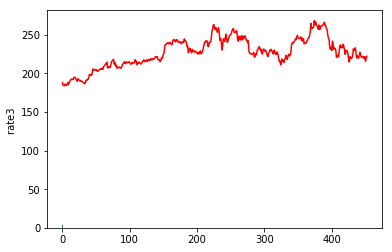

all average return rate 0.17735680366393522
True


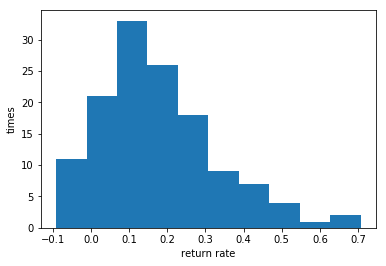

In [100]:
filename = 'Resnet'
if lstm == True:
    filename = 'LSTM'
days = 35

rate1_nn,_,Train_mses = test_tunnel(train_datas,indices=indices,days= days,std_n=2,filename=filename+'_Train',sell_signal_value=1,buy_signal_value=0)
rate2_nn,_,Val_mses  = test_tunnel(val_datas,indices=val_indices,days= days,std_n=2,filename=filename+'_val',sell_signal_value=1,buy_signal_value=0)
rate3_nn,_,Test_mses  = test_tunnel(test_datas,indices=test_indices,days= days,std_n=2,filename=filename+'_test',sell_signal_value=1,buy_signal_value=0)


rate = rate1_nn + rate2_nn +rate3_nn
#print('rate1,rate2,rate3',rate1,rate2,rate3)
#print(rate1_nn,rate2_nn,rate3_nn)
average_nn = np.mean(rate)


plt.hist(rate3_nn)
plt.ylabel('rate3 ')
plt.show()


print('all average return rate',average_nn)
print(average_nn>average)

plt.close('all')
plt.hist(rate)
plt.xlabel('return rate')
plt.ylabel('times')
#plt.show()
plt.savefig('Trade_pic/%s_average_return.png'%filename)


In [101]:
#RESNET no system dynamic no a normalization
system_dynamic,lstm,a_Normalization
# Trade_pic/Resnet_Train_predict_stockprice.png
# trade_time 86
# buy signal  86
# sell signal 146
# average rate return : 0.17588985328542114
# MSE Of a , 6.934987936573269

# Trade_pic/Resnet_val_predict_stockprice.png
# trade_time 31
# buy signal  34
# sell signal 33
# average rate return : 0.2621046796553357
# MSE Of a , 17.039818974182218

# Trade_pic/Resnet_test_predict_stockprice.png
# trade_time 17
# buy signal  23
# sell signal 43
# average rate return : 0.12433106641198544
# MSE Of a , 52.97665759829276

# all average return rate 0.18929403418556254
# True

(False, True, True)

In [102]:
#LSTM no system dynamic no a normalization
# Trade_pic/LSTM_Train_predict_stockprice.png
# trade_time 84
# buy signal  84
# sell signal 157
# average rate return : 0.15618440401320796
# MSE Of a , 7.19732418483681

# Trade_pic/LSTM_val_predict_stockprice.png
# trade_time 32
# buy signal  34
# sell signal 34
# average rate return : 0.2296960805071717
# MSE Of a , 17.1392771754386

# Trade_pic/LSTM_test_predict_stockprice.png
# trade_time 17
# buy signal  23
# sell signal 44
# average rate return : 0.12433106641198544
# MSE Of a , 52.082395346170294

# all average return rate 0.16979994467926854
# True


In [103]:
oringinal_Friction = sess.run(s_Friction)
s_Friction.assign(save_friction)

NameError: name 'save_friction' is not defined

#### sess.run(a,)

In [ ]:
acc,loss,t_acc = test(train_datas,indices)
acc,loss,t_acc = test(train_datas,indices,a=sd_a)#

In [ ]:
acc,loss,t_acc = test(val_datas,val_indices)


acc,loss,t_acc = test(val_datas,val_indices,a=sd_a)

In [ ]:

acc,loss,t_acc = test(test_datas,test_indices)
acc,loss,t_acc = test(test_datas,test_indices,a=sd_a)


In [ ]:
test_cycle(train_datas)
test_cycle(val_datas)
test_cycle(test_datas)



In [ ]:
negative = [f for f in Price_a if f <=0]
positive = [f for f in Price_a if f >0]

print(len(negative),len(positive))


In [ ]:
#test(test_datas,test_indices)


In [ ]:
# train_datas = _Nor_Price,_Nor_Quantity,_MarketValue,_Price_a,_TaxValue
# val_datas = val_nor_Price,val_nor_Quantity,val_MarketValue,val_Price_a,val_TaxValue
# test_datas = test_nor_Price,test_nor_Quantity,test_MarketValue,test_Price_a,test_TaxValue

In [ ]:
train_price = np.array(Price)[indices]
val_price = np.array(Price)[val_indices]
test_price = np.array(Price)[test_indices]

train_price_std = np.std(train_price)
val_price_std = np.std(val_price)
test_price_std = np.std(test_price)


In [ ]:
print(train_price_std,val_price_std,test_price_std)

In [ ]:
#store_price_a = store_price_a[1:]

In [ ]:
year_indices = []
start_year = 2007

for i in range(1,len(dates)):
    if dates[i][:4] in str(start_year):
        year_indices.append(i-1)
        start_year +=1
   

In [ ]:
year_indices

In [ ]:
indice_2016 = [f for f in indices if f >=1610 and f<1857]

In [ ]:
year2016_datas,_,_,_,_,_,_,_ = retriveFromdata([indice_2016,val_indices,test_indices])

In [ ]:
days = 20
filename = 'test'
rate3  = test_tunnel(year2016_datas,indices=indice_2016,days= days,std_n=2,filename=filename+'_test')



In [ ]:
indice_2017 = [f for f in test_indices if f  >=2342 and f<2585]

In [ ]:
year2017_datas,_,_,_,_,_,_,_ = retriveFromdata([indice_2017,val_indices,test_indices])

In [ ]:
rate3  = test_tunnel(year2017_datas,indices=indice_2017,days= days,std_n=2,filename=filename+'_test')



In [ ]:
rate3  = test_tunnel(year2017_datas+year2018_datas,indices=indice_2017+indice_2018,days= days,std_n=2,filename=filename+'_test')



In [ ]:
store_price_a[38]

In [ ]:
s = DeNormalization_a(Price_a[1][0],Price_a_max=Price_a_max,Price_a_min = Price_a_min)

In [ ]:
print(s)

In [ ]:
store_price_a[38]

In [ ]:
max(store_price_a),min(store_price_a)

In [ ]:
Price_a[1]

In [ ]:
store_price_a[37]

In [ ]:
Price[37],Price[37+5]

In [ ]:
restore_a(a=store_price_a[38],y_price=Price[38])

In [ ]:
Price_a[0]

In [ ]:
iii = 1
real_a = Price_a[iii][0]
#predict_a = DeNormalization_a(_a[i][0],Price_a_max=Price_a_max,Price_a_min=Price_a_min)
            
_index = indices[iii]#_indices[i] #NorPrice index 

#Price多第一天，故不取
#第1~36天
_last_prices = Price[_index+2:_index+2+OUTPUT_SIZE]
print(_last_prices)
#37天~41
_prices_for_predict = Price[_index+1+OUTPUT_SIZE+1:_index+1+OUTPUT_SIZE+1+t]
print(_prices_for_predict)
real_price = _prices_for_predict[-1]
close_price = _last_prices[-1]

predict_prices_trend_for_tunnel = Price[_index+1+OUTPUT_SIZE+1+t+1:_index+1+OUTPUT_SIZE+1+t+5]


#通道





assert len(_last_prices) == OUTPUT_SIZE
assert len(_prices_for_predict) == t
last_Price = _last_prices[-1]
#最後一天價格

#真實價格
print('last price',last_Price)
_real_price = restore_a(last_Price,real_a)
print('real a',real_a)
#real_prices.append(real_price)
print(_real_price,real_price)


In [ ]:

__a = 2*(60.8 -61.5) / (5**2)
print(__a)

_real_price = restore_a(last_Price,__a)
print(_real_price)

In [ ]:
indices[1]

In [ ]:
0.13415097* 0.6 + 0.14449972 * 0.2 + 0.33492452* 0.2

In [ ]:
(0.0852755900572736 - 0.07527706268355241) / 0.07527706268355241

In [ ]:
plt.plot(Price[1610+37:2000])
plt.show()

In [ ]:
rate1,ps,rs = test_tunnel(train_datas,indices=indices,Bband = True,days= days,std_n=2,filename='BBand_Train')
print(ps[:-10])

In [ ]:
0.07 * (Price_a_max-Price_a_min) + Price_a_min

In [ ]:
Price_a_min

In [ ]:
(0.20382745793516016 -0.15506558379002425 ) / 0.15506558379002425